In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde as kde
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

# Inference with ELFI: the MA(2) model

The 2nd order moving average model, MA(2), is a common model used in univariate time analysis. Assuming zero mean it can be written as

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim N(0,1)$ represents an independent and identically distributed sequence of white noise.

### The observed data and the inference problem

In this notebook, our task is to infer the parameters $\theta_1, \theta_2$ given a sequence of 100 observations $y$ that originate from an MA(2) process. Let's define this MA(2) simulator as a Python function:

In [2]:
def MA2(t1, t2, n_sim=1, prng=None):
    n_obs = 100
    if prng is None:
        prng = np.random.RandomState()
    w = prng.randn(n_sim, n_obs+2) # i.i.d. sequence ~ N(0,1)
    y = w[:,2:] + t1 * w[:,1:-1] + t2 * w[:,:-2]
    return y

In ELFI, all non-constant data is in at least 2-dimensional NumPy arrays with different observations on the 0-axis. **Important**: in order to guarantee a consistent state of pseudo-random number generation, the simulator must have `prng` as a keyword argument for reading in a `numpy.RandomState` object. Additionally, a simulator that supports vectorized operations should accept the keyword argument `n_sim` that defines how many sequences should be returned.

Let's now use this simulator to create the observations with true parameter values $\theta_1=0.6, \theta_2=0.2$ (from now on these are considered unknown):

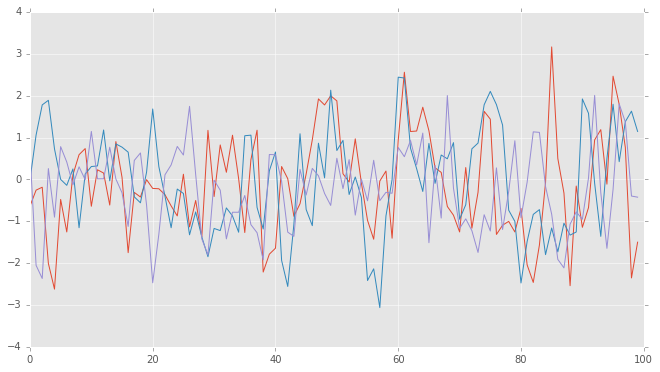

In [3]:
# true parameters
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y with some random seed
prng = np.random.RandomState(20170101)
y = MA2(t1_0, t2_0, prng=prng)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y.flatten());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_0, t2_0).flatten());
plt.plot(MA2(t1_0, t2_0).flatten());

### Approximate Bayesian Computation

In [4]:
import elfi

# a node is defined by giving it a name, a distribution from scipy.stats and its parents (here constants 0 and 2)
t1 = elfi.Prior('t1', scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('t2', 'uniform', 0, 2)

In [5]:
Y = elfi.Simulator('MA2', MA2, t1, t2, observed=y)

In [6]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True)
    return C

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d

In [7]:
S1 = elfi.Summary('S1', autocov, Y)

In [8]:
from functools import partial

# this is a more efficient way to say `lambda x: autocov(x, lag=2)`
autocov2 = partial(autocov, lag=2)

S2 = elfi.Summary('S2', autocov2, Y)

# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Discrepancy('d', distance, S1, S2)

Now that the inference model is defined, ELFI can visualize the DAG:

<a id='custom_prior'></a>


### Defining custom priors

In [9]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class MarinPrior_t1():
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class MarinPrior_t2():
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed sample from a triangle:

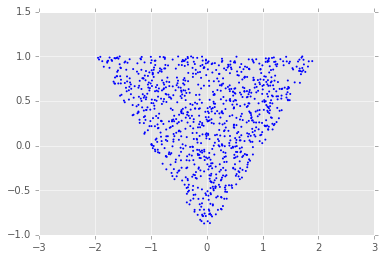

In [10]:
t1_1000 = MarinPrior_t1.rvs(2, 1000)
t2_1000 = MarinPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=4, edgecolor='none');

Let's change the earlier priors to the new ones in the inference model:

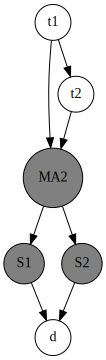

In [11]:
# define new priors
t1m = elfi.Prior('t1', MarinPrior_t1, 2)
t2m = elfi.Prior('t2', MarinPrior_t2, t1, 1)

# change these in place of the earlier nodes, keeping the old children
t1 = t1.change_to(t1m, transfer_parents=False, transfer_children=True)
t2 = t2.change_to(t2m, transfer_parents=False, transfer_children=True)

elfi.draw_model(d)

### Basic inference with rejection sampling

In [12]:
rej = elfi.Rejection(d, [t1, t2], batch_size=100000)

In [13]:
# Time and run the simulator
N = 1000
%time result_dict = rej.sample(N, quantile=0.001)

# The sample method returns a dictionary with an item `samples` that is a list of posteriors
[t1_post, t2_post] = result_dict['samples']

# print the threshold and posterior means
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result_dict['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

CPU times: user 10.9 s, sys: 1 s, total: 11.9 s
Wall time: 3.64 s
Number of accepted samples 1000 with threshold 0.04
Posterior means: 0.58 0.19


Rejection sampling can also be performed `threshold` based i.e. accepting all samples that result in a discrepancy below certain threshold.

In [14]:
%time result_dict2 = rej.sample(N, threshold=0.1)

CPU times: user 665 ms, sys: 53.1 ms, total: 718 ms
Wall time: 678 ms


### Visualizing inference

In [15]:
t1_post.shape

(1000, 1)

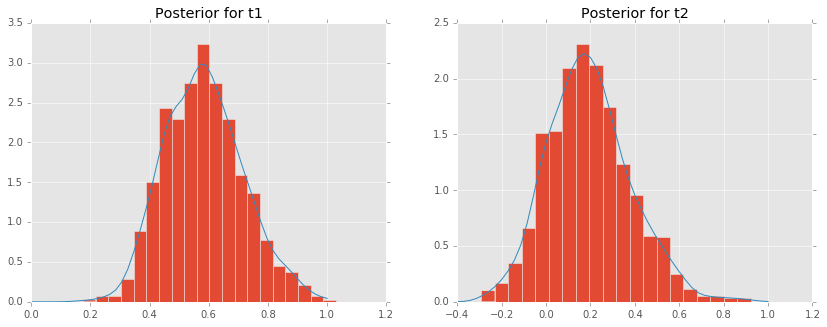

In [16]:
t1_post_kde = kde(t1_post.ravel())
t2_post_kde = kde(t2_post.ravel())

fig, ax = plt.subplots(ncols=2, figsize=(14,5));

ax[0].hist(t1_post, bins=20, normed=True);
ax[0].set_title("Posterior for t1");
ax[0].plot(np.linspace(0,1), t1_post_kde(np.linspace(0,1)))

ax[1].hist(t2_post, bins=20, normed=True);
ax[1].set_title("Posterior for t2");
ax[1].plot(np.linspace(-.4,1), t2_post_kde(np.linspace(-.4,1)));

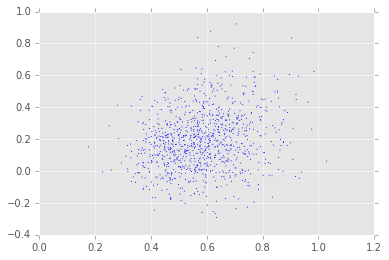

In [17]:
# A 2D visualization may be more appropriate
plt.scatter(t1_post, t2_post, s=1, edgecolor='none');

<a id='parallelization'></a>


### Automatic parallelization

Behind the scenes, ELFI uses the [Dask](http://dask.pydata.org/) library to automatically parallelize (most of) the computational inference. The parallelization can be tuned with the keyword argument `batch_size` for the Rejection class, which tells how many "runs"$^1$ should be sent to each available computational unit at a time. There is some overhead involved in the parallelization, so batches should be large, but not too large to eat all your memory.

$^1$To be more accurate, the MA2 model as well as the other functions in this example are vectorized, and the simulator is actually called just a few times with the keyword argument `n_sim` set to `batch_size`. This results in more efficient usage of numpy operations. Whenever possible, functions should be written in a form that allows vectorization.

The underlying Dask graph for our inference can be visualized (partly):

In [18]:
from dask.dot import dot_graph
# dot_graph(d[0:4].dask)

### Sequential Monte Carlo ABC

Rejection sampling is quite inefficient, as it does not learn from its history. The sequential Monte Carlo (SMC) ABC algorithm does just that by applying importance sampling: samples are *weighed* according to the resulting discrepancies and the next *population* of samples is drawn near to the previous using the weights as probabilities. 

For evaluating the weights, SMC ABC needs to have probability density functions for the priors. In our MA2 example the second prior is conditional on the first, which complicates matters a bit. Let's modify the prior distribution classes:

In [19]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class MarinPrior_t1():
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(t1, b):
        p = 1./b - np.abs(t1) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class MarinPrior_t2():
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
    def pdf(t2, _, a, all_samples):
        t1 = all_samples[0]
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(t2, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p
    
# define new priors
t1m = elfi.Prior('t1', MarinPrior_t1, 2)
t2m = elfi.Prior('t2', MarinPrior_t2, t1, 1)

# change these in place of the earlier nodes, keeping the old children
t1 = t1.change_to(t1m, transfer_parents=False, transfer_children=True)
t2 = t2.change_to(t2m, transfer_parents=False, transfer_children=True)

In ELFI, one can setup a SMC ABC sampler just like the Rejection sampler:

### Bayesian Optimization for Likelihood-Free Inference (BOLFI)

In practice inference problems often have a more complicated and computationally heavy simulator than the function `MA2` here, and one simply cannot run it for millions of times. The [BOLFI](https://arxiv.org/abs/1501.03291) framework is likely to prove useful in such situation: a statistical model (e.g. [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process)) is created for the discrepancy, and its minimum is inferred with [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization). This approach typically reduces the number of required simulator calls by several orders of magnitude.

As BOLFI is more advanced inference method, its interface is also a bit more involved. But not much: Using the same graphical model as earlier, the inference begins by defining a Gaussian process model, for which we use the [GPy](https://sheffieldml.github.io/GPy/) library. We are inferring 2 parameters with the same bounds as earlier, and we have to give these conditions to the surrogate model i.e. the Gaussian process.

In [20]:
gp_model = elfi.GPyModel(input_dim=2, bounds=((-2,2), (-1,1)))

In [21]:
# FIXME: BOLFI misuses old values. But .reset doesn't work either now!
[p.reset(propagate=True) for p in [t1, t2]];

In [22]:
# ... so redefine the model
t1 = elfi.Prior('t1', scipy.stats.uniform, 0, 2)
t2 = elfi.Prior('t2', 'uniform', 0, 2)
Y = elfi.Simulator('MA2', MA2, t1, t2, observed=y)
S1 = elfi.Summary('S1', autocov, Y)
S2 = elfi.Summary('S2', autocov2, Y)
d = elfi.Discrepancy('d', distance, S1, S2)

Taking a logarithm of the discrepancies reduces the effect that high discrepancies have on the GP.

In [23]:
log_distance = lambda s1,s2: np.log(distance(s1, s2))
d = d.change_to(elfi.Discrepancy('log_d', log_distance, S1, S2), transfer_parents=True)

Having defined the surrogate model, we can instantiate the BOLFI framework object in a somewhat similar way as earlier, except that we now additionally define the surrogate model and the number of samples to take from it (this is the number of simulator calls): 

In [24]:
bolfi = elfi.BOLFI(d, [t1, t2], batch_size=5, n_surrogate_samples=150, model=gp_model)

The BOLFI class can now try to `infer` the posterior distribution of the parameters:

In [25]:
# FIXME: get rid of WARNING logging from GPy related to GPy priors
post = bolfi.infer()

elfi.methods - INFO - BOLFI: Sampling 150 samples in batches of 5


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (-1.5586) as threshold


In [26]:
gp_model.gp

GP_regression.,value,constraints,priors
rbf.variance,0.263681385776,+ve,"Ga(0.01, 0.01)"
rbf.lengthscale,0.382835113219,+ve,"Ga(0.01, 0.01)"
Gaussian_noise.variance,0.299248923908,+ve,"Ga(0.01, 0.01)"


We can get estimates for *maximum a posteriori* and *maximum likelihood* easily:

We can also plot the Gaussian process using GPy:

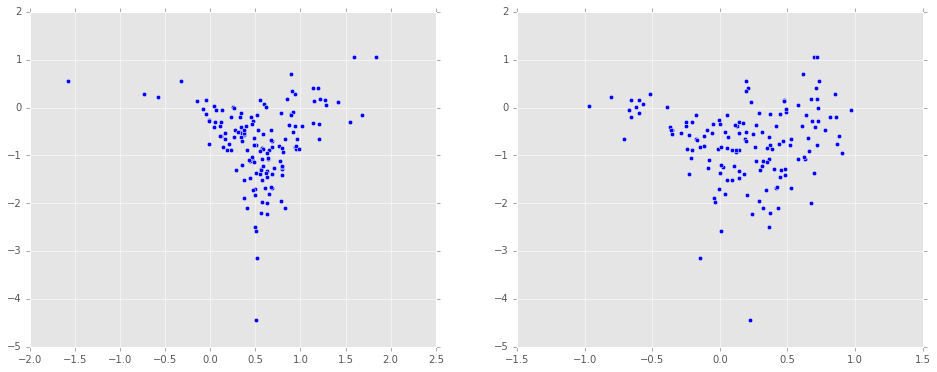

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].scatter(bolfi.model.gp.X[:,0], bolfi.model.gp.Y[:,0]);
ax[1].scatter(bolfi.model.gp.X[:,1], bolfi.model.gp.Y[:,0]);

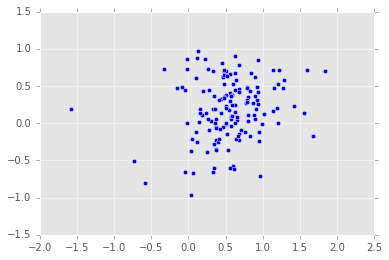

In [28]:
plt.scatter(bolfi.model.gp.X[:,0], bolfi.model.gp.X[:,1])

In [29]:
post = bolfi.get_posterior(threshold=np.log(0.04))

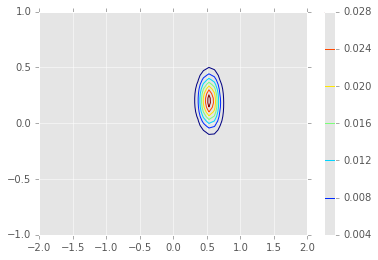

In [30]:
x, y = np.meshgrid(np.linspace(*bolfi.model.bounds[0]), np.linspace(*bolfi.model.bounds[1]))
z = np.empty_like(x)
for ii in range(len(x)):
    for jj in range(len(x)):
        z[ii, jj] = post.pdf(np.array([x[ii, jj], y[ii, jj]]))
# Normalize
dx = x[0,1]-x[0,0]
dy = y[1,0]-y[0,0]
z = z-np.min(z)
z = z/np.sum(z)
plt.contour(x, y, z)
plt.colorbar()

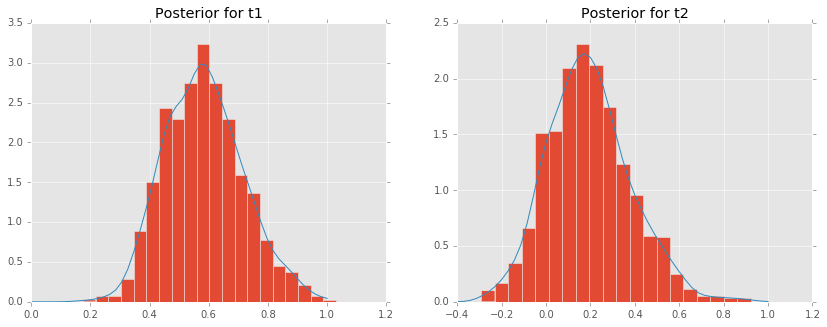

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));

ax[0].hist(t1_post, bins=20, normed=True);
ax[0].set_title("Posterior for t1");
ax[0].plot(np.linspace(0,1), t1_post_kde(np.linspace(0,1)))

ax[1].hist(t2_post, bins=20, normed=True);
ax[1].set_title("Posterior for t2");
ax[1].plot(np.linspace(-.4,1), t2_post_kde(np.linspace(-.4,1)));

In [32]:
matplotlib.rcParams.update({'font.size': 14})

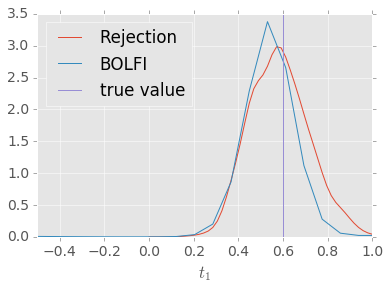

In [38]:
plt.plot(np.linspace(0,1), t1_post_kde(np.linspace(0,1)), label='Rejection');
plt.plot(np.linspace(*bolfi.model.bounds[0]), np.sum(z/dx, axis=0), label='BOLFI')
plt.plot([.6,.6], [0,3.5], label='true value')
plt.xlim([-.5, 1])
plt.ylim([0,3.5])
plt.legend(loc=2);
plt.xlabel('$t_1$');
plt.savefig('t1.png', bbox_inches='tight', dpi=300)

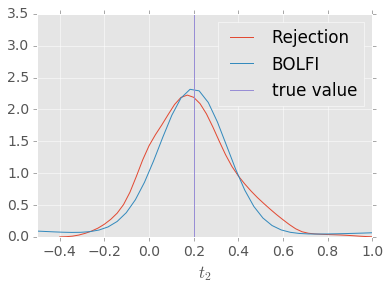

In [39]:
plt.plot(np.linspace(-.4,1), t2_post_kde(np.linspace(-.4,1)), label='Rejection');
plt.plot(np.linspace(*bolfi.model.bounds[1]), np.sum(z/dy, axis=1), label='BOLFI')
plt.plot([.2,.2], [0,3.5], label='true value')
plt.xlim([-.5, 1]);
plt.ylim([0,3.5])
plt.legend(loc=1);
plt.xlabel('$t_2$');
plt.savefig('t2.png', bbox_inches='tight', dpi=300)

 /home/lintusj1/anaconda2/envs/abc4py/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


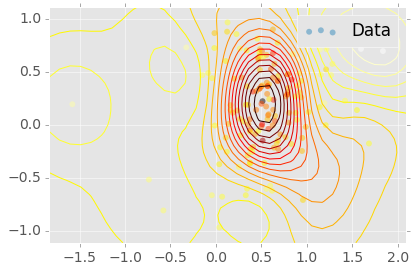

In [40]:
bolfi.model.gp.plot();
plt.savefig('gp.png', bbox_inches='tight', dpi=300)

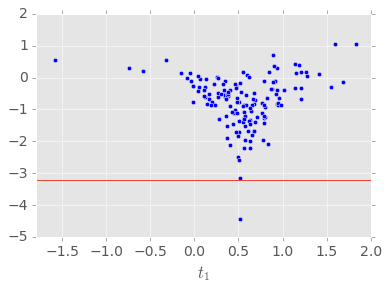

In [45]:
plt.scatter(bolfi.model.gp.X[:,0], bolfi.model.gp.Y[:,0], label='distances');
plt.plot([-1.8, 2], [np.log(0.04), np.log(0.04)], label='threshold')
plt.xlim([-1.8,2])
plt.xlabel('$t_1$');
#plt.plot([])
